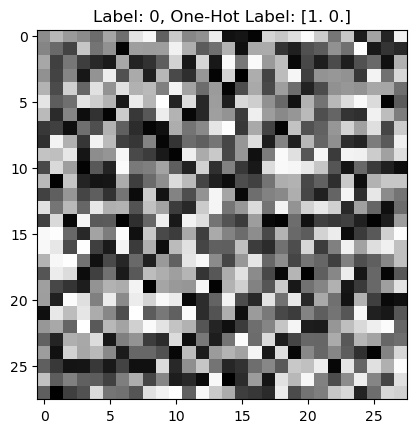

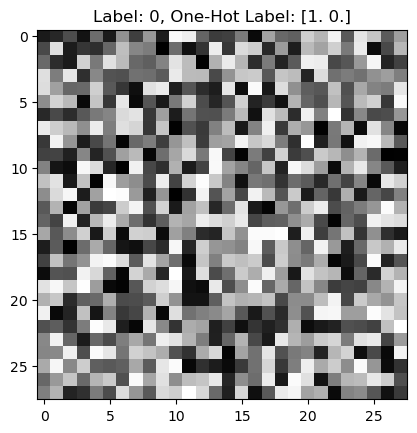

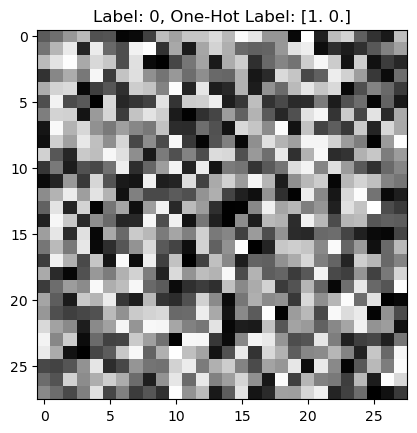

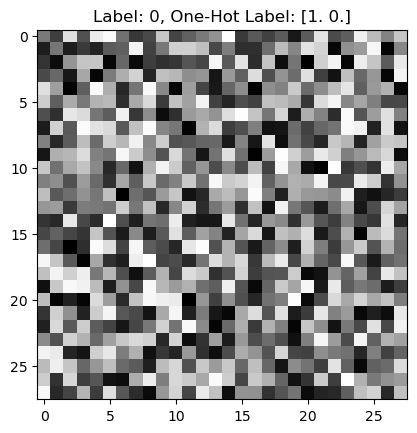

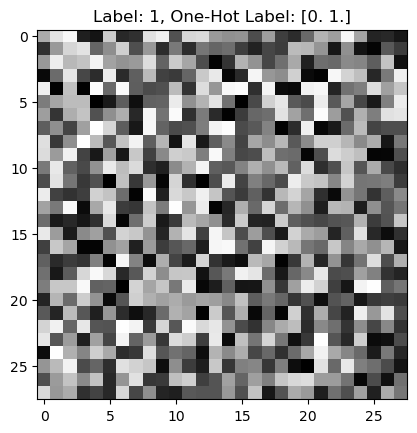

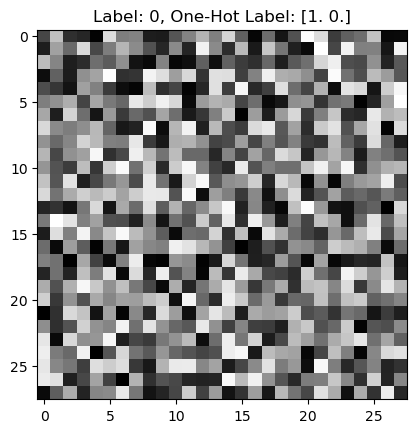

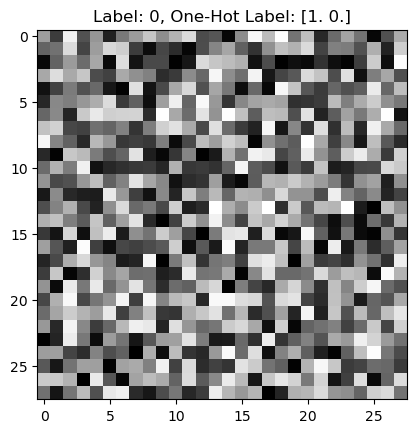

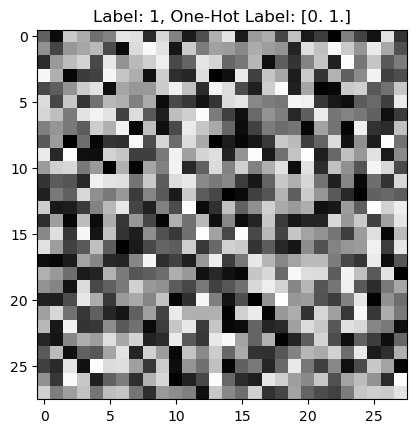

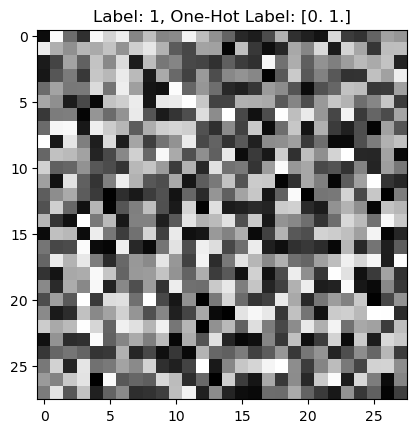

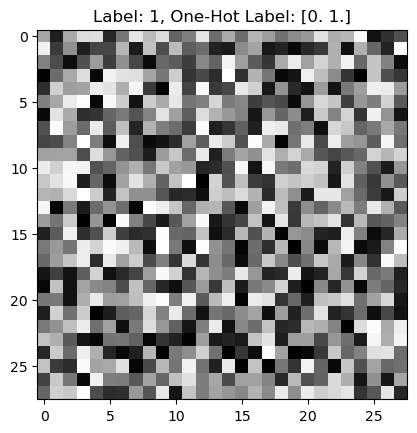

ValueError: zero-size array to reduction operation maximum which has no identity

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic images and labels
np.random.seed(0)

num_samples = 10
image_size = 28
num_classes = 2  # Binary classification (0 or 1)

# Create synthetic image data
images = np.random.rand(num_samples, image_size, image_size)

# Create synthetic labels (0 or 1)
labels = np.random.randint(0, num_classes, size=num_samples)

# One-hot encoding for labels (for multi-class classification)
def one_hot_encode(labels, num_classes):
    encoded_labels = np.zeros((len(labels), num_classes))
    for i in range(len(labels)):
        encoded_labels[i, labels[i]] = 1
    return encoded_labels

labels_one_hot = one_hot_encode(labels, num_classes)

# Display sample images and labels
for i in range(num_samples):
    plt.imshow(images[i], cmap='gray')
    plt.title(f"Label: {labels[i]}, One-Hot Label: {labels_one_hot[i]}")
    plt.show()

# Define a simple CNN architecture
# Here, we use only one convolutional layer, one fully connected layer, and a softmax output layer for binary classification.
# You can expand this architecture for more complex tasks.
num_filters = 8
filter_size = 3
pool_size = 2
learning_rate = 0.01
epochs=10

# Initialize weights and biases
conv_weights = np.random.randn(num_filters, filter_size, filter_size)
conv_bias = np.zeros((num_filters,))
fc_weights = np.random.randn(num_filters * (image_size // pool_size) * (image_size // pool_size), num_classes)
fc_bias = np.zeros((num_classes,))

# Define the sigmoid activation function and its derivative
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

# Forward propagation
def forward_propagation(input_data):
    # Convolutional layer
    conv_output = np.zeros((num_samples, num_filters, image_size - filter_size + 1, image_size - filter_size + 1))
    for sample in range(num_samples):
        for f in range(num_filters):
            for i in range(image_size - filter_size + 1):
                for j in range(image_size - filter_size + 1):
                    conv_output[sample, f, i, j] = np.sum(input_data[sample, i:i+filter_size, j:j+filter_size] * conv_weights[f]) + conv_bias[f]

    # Apply sigmoid activation
    conv_output = sigmoid(conv_output)

    # Max-pooling layer
    pooled_output = np.zeros((num_samples, num_filters, image_size // pool_size, image_size // pool_size))
    for sample in range(num_samples):
        for f in range(num_filters):
            for i in range(0, image_size, pool_size):
                for j in range(0, image_size, pool_size):
                    pooled_output[sample, f, i // pool_size, j // pool_size] = np.max(conv_output[sample, f, i:i+pool_size, j:j+pool_size])

    # Flatten the pooled output
    flattened = pooled_output.reshape((num_samples, -1))

    # Fully connected layer
    fc_output = np.dot(flattened, fc_weights) + fc_bias

    # Apply softmax activation
    exp_fc_output = np.exp(fc_output - np.max(fc_output, axis=1, keepdims=True))
    softmax_output = exp_fc_output / np.sum(exp_fc_output, axis=1, keepdims=True)

    return softmax_output

# Backpropagation
def backpropagation(input_data, softmax_output, labels_one_hot):
    # Calculate the loss (cross-entropy)
    loss = -np.sum(labels_one_hot * np.log(softmax_output)) / num_samples

    # Calculate the gradient of the loss with respect to the softmax output
    d_loss = (softmax_output - labels_one_hot) / num_samples

    # Backpropagate through the fully connected layer
    d_fc_weights = np.dot(input_data.T, d_loss)
    d_fc_bias = np.sum(d_loss, axis=0, keepdims=True)

    # Calculate the gradient of the loss with respect to the flattened pooled output
    d_flattened = np.dot(d_loss, fc_weights.T)

    # Reshape the gradient to match the shape of the pooled output
    d_pooled_output = d_flattened.reshape(pooled_output.shape)

    # Backpropagate through the max-pooling layer
    d_conv_output = np.zeros(conv_output.shape)
    for sample in range(num_samples):
        for f in range(num_filters):
            for i in range(0, image_size, pool_size):
                for j in range(0, image_size, pool_size):
                    window = conv_output[sample, f, i:i+pool_size, j:j+pool_size]
                    mask = (window == np.max(window))
                    d_conv_output[sample, f, i:i+pool_size, j:j+pool_size] = d_pooled_output[sample, f, i // pool_size, j // pool_size] * mask

    # Calculate the gradient of the loss with respect to the conv_weights
    d_conv_weights = np.zeros(conv_weights.shape)
    d_conv_bias = np.zeros(conv_bias.shape)
    for sample in range(num_samples):
        for f in range(num_filters):
            for i in range(image_size - filter_size + 1):
                for j in range(image_size - filter_size + 1):
                    d_conv_weights[f] += input_data[sample, i:i+filter_size, j:j+filter_size] * d_conv_output[sample, f, i, j]
                    d_conv_bias[f] += d_conv_output[sample, f, i, j]

    return loss, d_conv_weights, d_conv_bias, d_fc_weights, d_fc_bias

# Training loop
for epoch in range(epochs):
    # Forward propagation
    softmax_output = forward_propagation(images)

    # Backpropagation
    loss, d_conv_weights, d_conv_bias, d_fc_weights, d_fc_bias = backpropagation(images, softmax_output, labels_one_hot)

    # Update weights and biases using gradient descent
    conv_weights -= learning_rate * d_conv_weights
    conv_bias -= learning_rate * d_conv_bias
    fc_weights -= learning_rate * d_fc_weights
    fc_bias -= learning_rate * d_fc_bias

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# Make predictions
def predict(input_data):
    softmax_output = forward_propagation(input_data)
    return (softmax_output[:, 1] > 0.5).astype(int)

# Test the model with new data
test_images = np.random.rand(3, image_size, image_size)
predictions = predict(test_images)
print("Predictions:", predictions)


In [21]:
images.shape

(10, 28, 28)